# Features that impact listing price

## Import Data and Library

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# reviews.csv will not be used in the analysis due to limited usability
calendar_csv = pd.read_csv('./project_1/calendar.csv')
listings_csv = pd.read_csv('./project_1/listings.csv')

## Project Motivation

In the first question we were trying to find out which features impact the daily rent price of the listing in Seattle. We have looked at various variables available in the dataset to try and predict which have the greatest impact on the price.

Several methods of analysis have been incorporated in order to best present the problem at hand. Graphs, tables and a simple MLR model have been implemented. More details below...

## Data Cleaning and Preperation

Due to the unstructured format in which the .csv files are presented a lot of time and effort had to be invested in cleaning the data.

First we have checked for missing values in both datasets and dropped variables with more than 50% of the rows missing.

In [4]:
miss_calendar = calendar_csv.isnull().mean() * 100
miss_listings = pd.DataFrame(listings_csv.isnull().mean() * 100, columns=['missing'])

No columns were dropped from **calendar_csv** but four columns had to be dropped from **listings_csv** due to the amount of missing values.

In [5]:
# No columns to drop from 'calendar_csv'
miss_calendar

listing_id     0.000000
date           0.000000
available      0.000000
price         32.938998
dtype: float64

In [6]:
# Four columns had to be dropped from 'listings_csv' due to amount of missing values
miss_listings[miss_listings.missing>0].sort_values(by='missing', ascending=False)

,missing
license,100.000000
square_feet,97.459403
monthly_price,60.267156
security_deposit,51.126244
weekly_price,47.380828
notes,42.063908
neighborhood_overview,27.029859
cleaning_fee,26.977475
transit,24.463070
host_about,22.498690


We have then merged the two datasets using a _left_join_ on the **calendar_csv** to obtain a full timeseries of bookings and listing information.

In [7]:
# remove columns with more than half of the data missing and merge the two databases
listings_removed_cols = miss_listings[miss_listings.missing > 50]
listings_subset = listings_csv.loc[:, ~listings_csv.columns.isin(listings_removed_cols.index)]
listings_full = pd.merge(left=calendar_csv, right=listings_subset, how='left', left_on='listing_id',
                         right_on='id')

The next order of business was to clean the data by replacing values with more meaningful descriptors, parsing numercial variables and reducing the size of the data frame in order to speed up the calculations.

In [8]:
# remove URL columns which are redundant
url_cols = listings_full.filter(like='url')
listings_full = listings_full.loc[:, ~listings_full.columns.isin(url_cols.columns)]

# rename 'price' columns
listings_full.rename(columns={'price_x': 'price'}, errors='raise', inplace=True)

# replace values with meaningful descriptors
cols_to_replace = {
    'host_is_superhost': {'t': 'superhost', 'f': 'regular'},
    'available': {'t': 'free', 'f': 'booked'}
}

for k, v in cols_to_replace.items():
    listings_full[k].replace(
        to_replace=v,
        inplace=True
    )

# add 'year' and 'month' variables
listings_full['year'] = pd.DatetimeIndex(listings_full['date']).year
listings_full['month'] = pd.DatetimeIndex(listings_full['date']).month

# drop cols with single unique value
cols_len_one = []

for i in listings_full.columns:
    if len(listings_full[i].unique()) == 1:
        cols_len_one.append(i)

listings_full = listings_full.loc[:, ~listings_full.columns.isin(cols_len_one)]

# reformat price columns into a float dtype
for col in ['price', 'weekly_price', 'cleaning_fee', 'extra_people']:
    listings_full[col] = listings_full[col].str.replace(',', '').str.replace('$', '').astype(float)

# reformat 'host_response_rate'
listings_full.host_response_rate = listings_full.host_response_rate.str.replace('%', '').astype(float) / 100

# further remove redundant columns
cols_to_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit',
                'host_name', 'host_location', 'host_about', 'street', 'neighborhood_overview', 'zipcode',
                'smart_location', 'latitude', 'longitude', 'price_y', 'calendar_updated', 'neighbourhood',
                'host_acceptance_rate', 'state', 'city', 'is_location_exact']

listings_full = listings_full.loc[:, ~listings_full.columns.isin(cols_to_drop)]

Next, we have to drop missing rows from the  _**price**_ column.

In [9]:
# Remove NA from predictive vriable
price = listings_full.iloc[:, [3, 1, 4]].dropna(axis=0)

value_listings_db = pd.merge(left=listings_full, right=price, how='inner', on=['date', 'id'])
value_listings_db.drop(axis=1, labels='price_y', inplace=True)
value_listings_db.rename(columns={'price_x': 'price'}, errors='raise', inplace=True)

## Data Analysis

### Correlation plot

Finnaly we were ready to conduct some data analysis. We started off with a correlation plot of numerical variables to see if any strong correlations exist with our response variable

AxesSubplot(0.125,0.125;0.62x0.755)


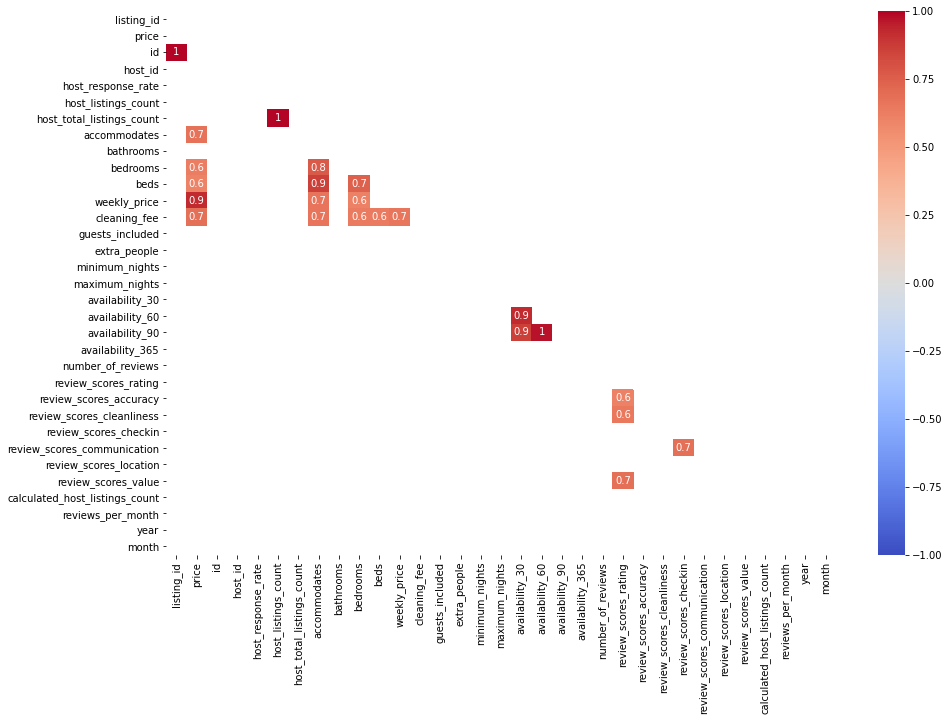

In [10]:
def correlation_matrix():
    '''
    Creates a correlation plot from numeric variables and plots values which are correlated > 0.6 with
    price
    '''

    num_cols = []

    for i in value_listings_db:

        if value_listings_db[i].dtype in ('float64', 'int64'):
            num_cols.append(i)

    value_cor_db = value_listings_db.iloc[:, value_listings_db.columns.isin(num_cols)]

    # check for correlation between variables
    value_cor = value_cor_db.corr()
    matrix = np.triu(value_cor_db.corr())

    print(
        sns.heatmap(value_cor[value_cor > .6], annot=True, fmt='.1g', vmin=-1, vmax=1, center=0,
                    cmap='coolwarm', mask=matrix)
    )


f, ax = plt.subplots(1, 1, figsize = (15, 10))
correlation_matrix()

We can observe several variables which are highly correlated with price:


>- accomodates
- bedrooms
- beds
- weekly_price
- cleaning_fee

Additionally, we can see that these variables are highly correlated with each other which is something we should keep in mind as we continue our analysis.

### Plotting and Aggregating Data

Next we introduce some graphs and data aggregation to get a feel for our dataset.

Looking at the _property_type_ variable we can see that the mean price of properties in the observed period reaches up to ~160$ per day with the exception of boats which are almost double the price. Looking at the table at the bottom we can see that there are not that many boats available and so this category can be treated as an outlier.

Text(0, 0.5, 'Avg. $ price')

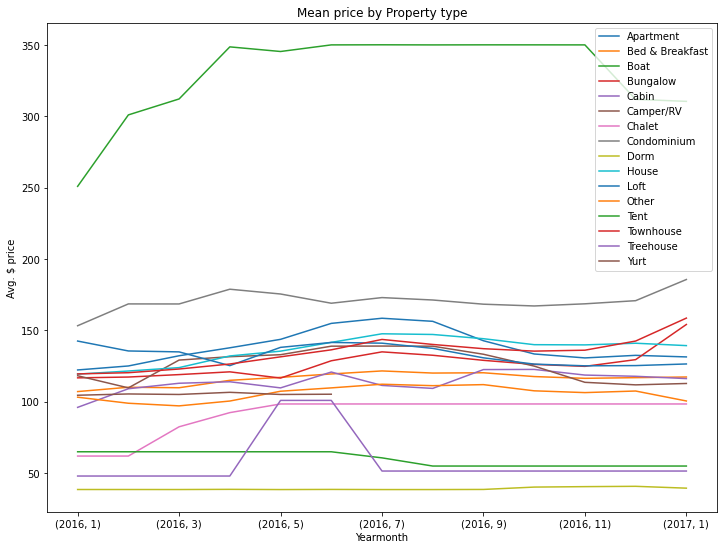

In [11]:
# property type
f, ax = plt.subplots(1, 1, figsize = (12, 9))
value_listings_db.pivot_table(index=['year', 'month'], values='price', columns='property_type', aggfunc=np.mean).plot(
    title='Mean price by Property type', ax=ax).legend(loc='upper right')
plt.xlabel("Yearmonth")
plt.ylabel("Avg. $ price")

In fact we can only use **houses** and **appartments** and potentially **townhouses** and **condos** for our analysis since the rest of the properties present less than 5% of total listings in the sample.

In [12]:
property_type_agg = value_listings_db.pivot_table(index=['property_type'], values='listing_id', aggfunc=pd.Series.nunique).sort_values(
    by='listing_id', ascending=False)

property_type_agg['listing_pct']=(property_type_agg.listing_id/sum(property_type_agg.listing_id))*100

property_type_agg

,listing_id,listing_pct
property_type,,
House,1686,45.298227
Apartment,1667,44.787749
Townhouse,117,3.143471
Condominium,88,2.364320
Loft,40,1.074691
Bed & Breakfast,36,0.967222
Other,22,0.591080
Cabin,20,0.537346
Bungalow,13,0.349275


Looking at the _room_type_ variable we can see a clear distinction in the price between various types of rentings. `Entire home/apt` definately has an edge in terms of average rental price.

Text(0, 0.5, 'Avg. $ price')

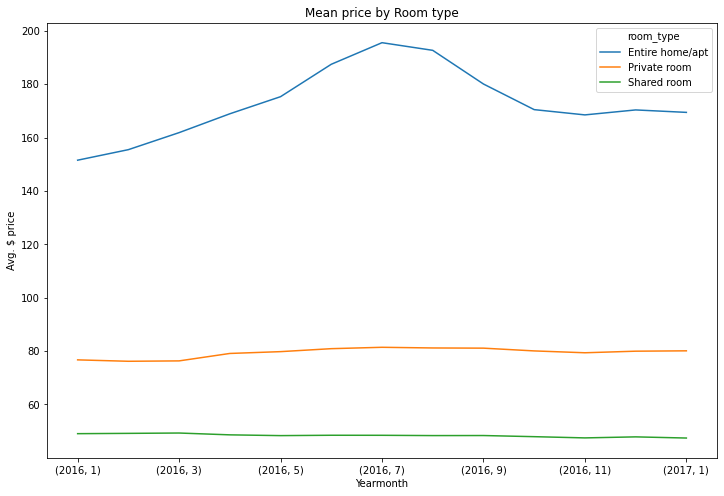

In [13]:
f, ax = plt.subplots(1, 1, figsize = (12, 8))
value_listings_db.pivot_table(index=['year', 'month'], values='price', columns='room_type', aggfunc=np.mean).plot(
    ax=ax, title='Mean price by Room type')
plt.xlabel("Yearmonth")
plt.ylabel("Avg. $ price")

Moving on to _accommodates_ we can observe that the majority of listings houses up to 6 people which coincides with the fact that the majority of property types are houses and apartments. Additionally, the price of the listing increases fairly linearly with the number of people it accommodates so no surprises there.

Text(0, 0.5, 'Average price')

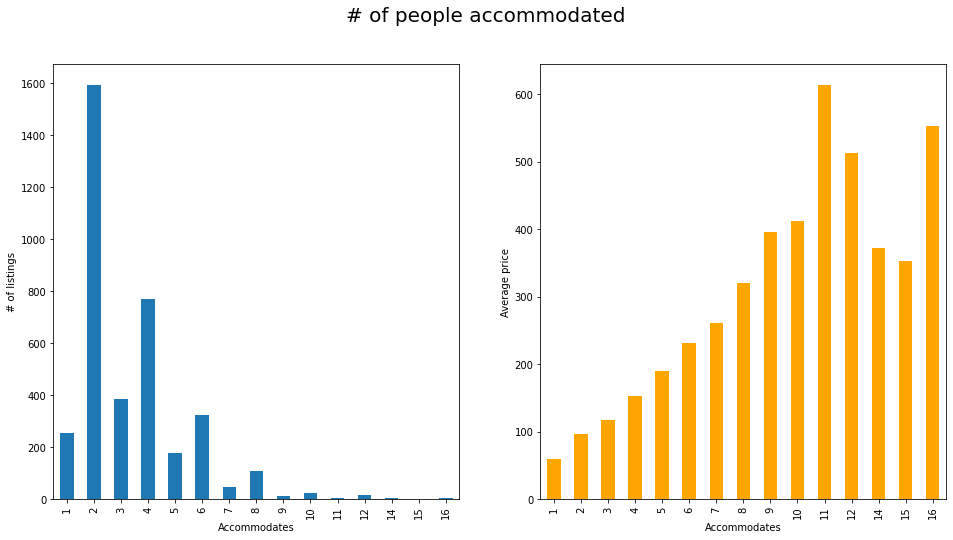

In [14]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
value_listings_db.pivot_table(values='listing_id', index='accommodates', aggfunc=pd.Series.nunique).plot(
    kind='bar', ax=axs[0], legend=False)
value_listings_db.pivot_table(values='price', index='accommodates', aggfunc=np.mean).plot(
    kind='bar', color='orange', ax=axs[1], legend=False)
plt.suptitle('# of people accommodated', size=20)
plt.setp(axs[[0,1]], xlabel='Accommodates')
axs[0].set_ylabel('# of listings')
axs[1].set_ylabel('Average price')

Another interesting variable to look at is the _cancelation_policy_ which indicates the kind of policy the host keeps in case of cancellations.

We can observe that the majority of hosts relys on **strict** cancellation policy which interestingly conincides with higher average price of those listings.

Text(0, 0.5, 'Average price')

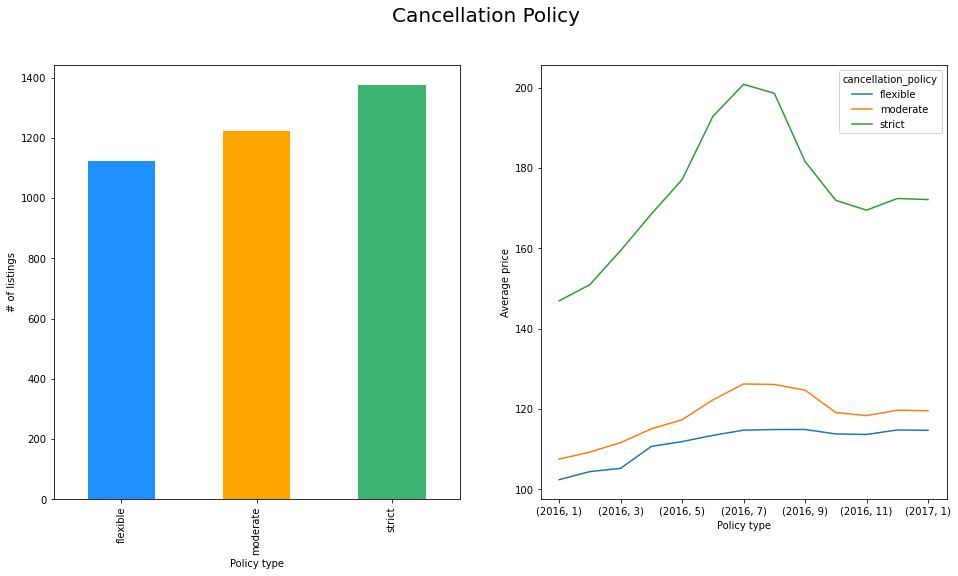

In [109]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
value_listings_db.pivot_table(values='listing_id', columns=['cancellation_policy'],aggfunc=pd.Series.nunique).T.plot(
    kind='bar', ax=axs[0], color=[['dodgerblue', 'orange', 'mediumseagreen']], legend=False)
value_listings_db.pivot_table(values='price', index=['year', 'month'], columns=['cancellation_policy'], aggfunc=np.mean).plot(
    ax=axs[1])
plt.suptitle('Cancellation Policy', size=20)
plt.setp(axs[[0,1]], xlabel='Policy type')
axs[0].set_ylabel('# of listings')
axs[1].set_ylabel('Average price')

### Regression model

Now that we have singeled out a few relevant variables we can apply a simple regression model to confirm our observations.

We will start out by creating some dummy variables from existing categoricals since we can only apply the model to numreical variables.

In [15]:
# apply a multiple regression model
dummy_cols = ['available',
              'host_response_time',
              'host_is_superhost',
              'host_has_profile_pic',
              'host_identity_verified',
              'property_type',
              'room_type',
              'bed_type',
              'instant_bookable',
              'cancellation_policy',
              'require_guest_profile_picture',
              'require_guest_phone_verification']

value_listings_lr = pd.get_dummies(value_listings_db, columns=dummy_cols)

In [16]:
value_listings_lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 934541
Data columns (total 86 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   listing_id                             934542 non-null  int64  
 1   date                                   934542 non-null  object 
 2   price                                  934542 non-null  float64
 3   id                                     934542 non-null  int64  
 4   host_id                                934542 non-null  int64  
 5   host_since                             934450 non-null  object 
 6   host_response_rate                     826028 non-null  float64
 7   host_neighbourhood                     859354 non-null  object 
 8   host_listings_count                    934450 non-null  float64
 9   host_total_listings_count              934450 non-null  float64
 10  host_verifications                     934542 non-null  

Next, we choose a set of variables which could potentially predict the daily listing price. We should be careful to avoid any varibles which are higly correlated with the dependent variable - price - due to multicollinearity (more on this [here](https://en.wikipedia.org/wiki/Multicollinearity)).

The intial set consisted of the following predictor variables:
- accommodates
- cancellation_policy_strict
- property_type_Apartment
- property_type_Condominium
- property_type_House
- property_type_Townhouse

The last two variables had little effect in explaining the price of the listing so we have decided to drop them in order to reduce the number of variables and avoid overfitting the model. Following this were left with four variables in our model and barely a reduction in our Adj. R-sq value. Below is a detailed summary of the results.

In [22]:
intial_set = [2, 13, 81, 53, 60]
lr_test_set = value_listings_lr.iloc[:, lambda value_listing_lr: intial_set]
lr_test_clean = lr_test_set.dropna(axis=0)

model = sm.OLS(lr_test_clean.price, lr_test_clean.drop(axis=1, columns='price'))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.803
Model:                            OLS   Adj. R-squared (uncentered):              0.803
Method:                 Least Squares   F-statistic:                          9.535e+05
Date:                Wed, 16 Jun 2021   Prob (F-statistic):                        0.00
Time:                        22:28:10   Log-Likelihood:                     -5.3846e+06
No. Observations:              934542   AIC:                                  1.077e+07
Df Residuals:                  934538   BIC:                                  1.077e+07
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
accommodates                  36.5349      0.029   1250.751      0.000      36.478      36.592
cancellation_policy_strict    18.2999      0.171    106.880      0.000      17.964      18.635
property_type_Apartment       14.9431      0.146    102.268      0.000      14.657      15.229
property_type_Condominium     31.8054      0.562     56.570      0.000      30.703      32.907
==============================================================================
Omnibus:                   641515.224   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25226448.495
Skew:                           2.811   Prob(JB):                         0.00
Kurtosis:                      27.824   Cond. No.                         27.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""